In [6]:
import pandas as pd

# Load the dataset
file_path = "FilteredData.csv"  # Update this path if needed
data = pd.read_csv(file_path)

# Display the first few rows
data.head()


,ClientID,CycleNumber,Group,CycleWithPeakorNot,ReproductiveCategory,LengthofCycle,MeanCycleLength,EstimatedDayofOvulation,LengthofLutealPhase,FirstDayofHigh,...,Method,Prevmethod,Methoddate,Whychart,Nextpreg,NextpregM,Spousesame,SpousesameM,Timeattemptpreg,BMI
0,nfp8122,1,0,1,0,29,27.33,17,12,12,...,9,,,2,7,7,1,1,0,21.254724111867
1,nfp8122,2,0,1,0,27,,15,12,13,...,,,,,,,,,,
2,nfp8122,3,0,1,0,29,,15,14,,...,,,,,,,,,,
3,nfp8122,4,0,1,0,27,,15,12,13,...,,,,,,,,,,
4,nfp8122,5,0,1,0,28,,16,12,12,...,,,,,,,,,,


#cleaning the data 

In [7]:
# Drop irrelevant columns
irrelevant_columns = [
    "ClientID", "Spousesame", "SpousesameM", "Nextpreg", "NextpregM", 
    "Whychart", "Prevmethod", "Method", "Methoddate", "Ethnicity", 
    "EthnicityM", "Maristatus", "MaristatusM"
]
data = data.drop(columns=irrelevant_columns)


In [9]:
# Replace blanks with NaN for proper handling
data = data.replace("", pd.NA)

# Fill missing BMI with the mean
data["BMI"] = pd.to_numeric(data["BMI"], errors="coerce")  # Convert to numeric
data["BMI"] = data["BMI"].fillna(data["BMI"].mean())

# Drop rows where "EstimatedDayofOvulation" is missing
data = data.dropna(subset=["EstimatedDayofOvulation"])

# Ensure numeric conversion for "EstimatedDayofOvulation" 
data["EstimatedDayofOvulation"] = pd.to_numeric(data["EstimatedDayofOvulation"], errors="coerce")


In [10]:
# Convert critical columns to numeric
numeric_columns = ["CycleNumber", "LengthofCycle", "EstimatedDayofOvulation"]
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")


In [11]:
# Remove outliers in cycle length
data = data[(data["LengthofCycle"] >= 20) & (data["LengthofCycle"] <= 40)]


In [12]:
data.rename(columns={
    "LengthofCycle": "Cycle Length",
    "CycleNumber": "Cycle Number",
    "EstimatedDayofOvulation": "Ovulation Day"
}, inplace=True)


#visualizations

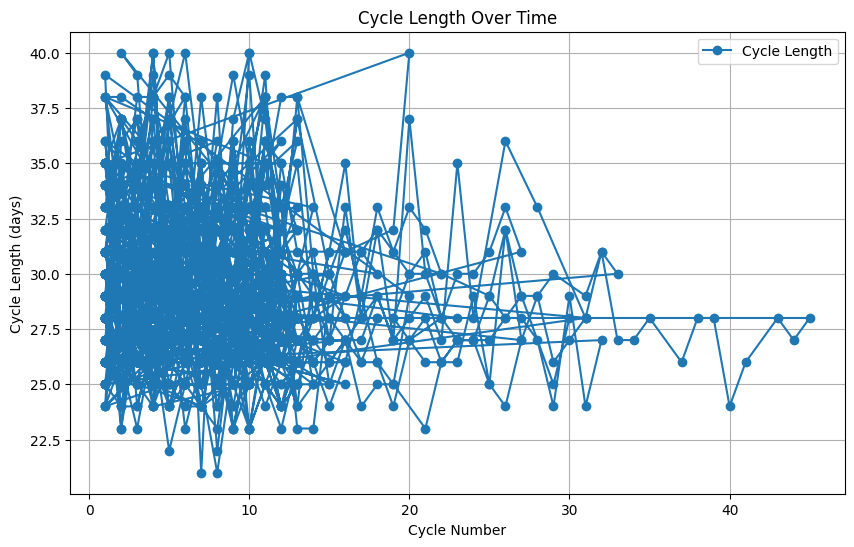

In [13]:
import matplotlib.pyplot as plt

# Plot cycle lengths over time
plt.figure(figsize=(10, 6))
plt.plot(data["Cycle Number"], data["Cycle Length"], marker="o", label="Cycle Length")
plt.title("Cycle Length Over Time")
plt.xlabel("Cycle Number")
plt.ylabel("Cycle Length (days)")
plt.grid(True)
plt.legend()
plt.show()


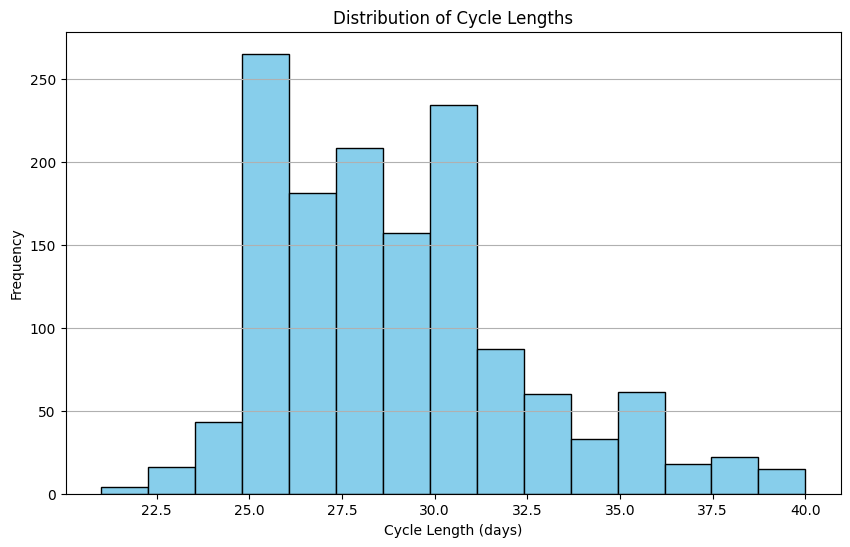

In [14]:
# Histogram of cycle lengths
plt.figure(figsize=(10, 6))
plt.hist(data["Cycle Length"], bins=15, color="skyblue", edgecolor="black")
plt.title("Distribution of Cycle Lengths")
plt.xlabel("Cycle Length (days)")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()


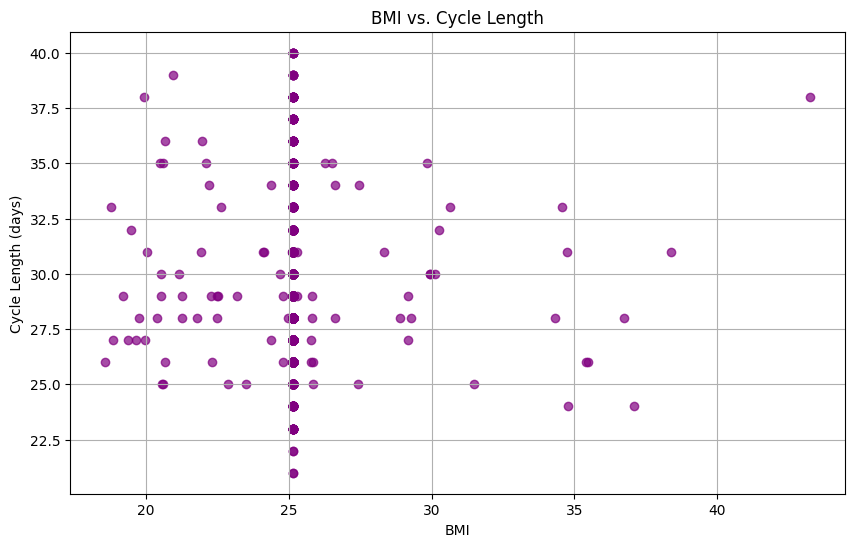

In [15]:
# Scatter plot: BMI vs Cycle Length
plt.figure(figsize=(10, 6))
plt.scatter(data["BMI"], data["Cycle Length"], alpha=0.7, color="purple")
plt.title("BMI vs. Cycle Length")
plt.xlabel("BMI")
plt.ylabel("Cycle Length (days)")
plt.grid(True)
plt.show()


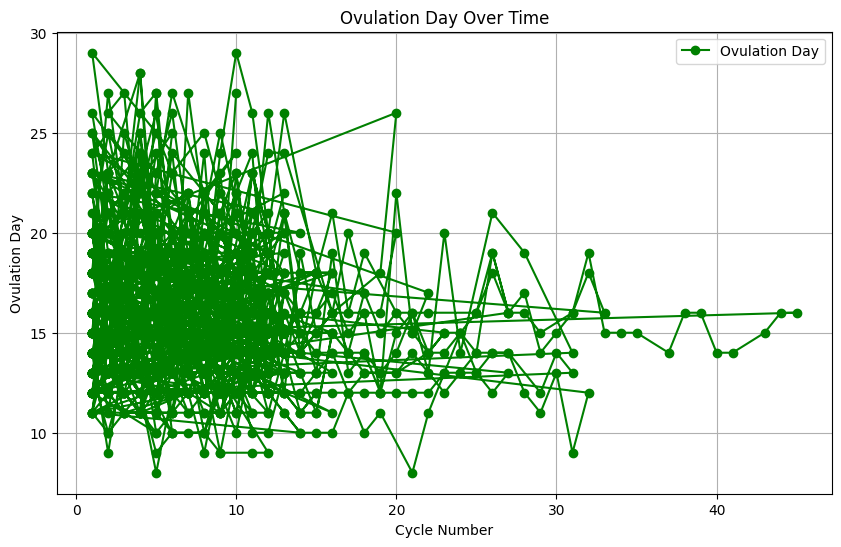

In [16]:
# Plot ovulation day over time
plt.figure(figsize=(10, 6))
plt.plot(data["Cycle Number"], data["Ovulation Day"], marker="o", color="green", label="Ovulation Day")
plt.title("Ovulation Day Over Time")
plt.xlabel("Cycle Number")
plt.ylabel("Ovulation Day")
plt.grid(True)
plt.legend()
plt.show()


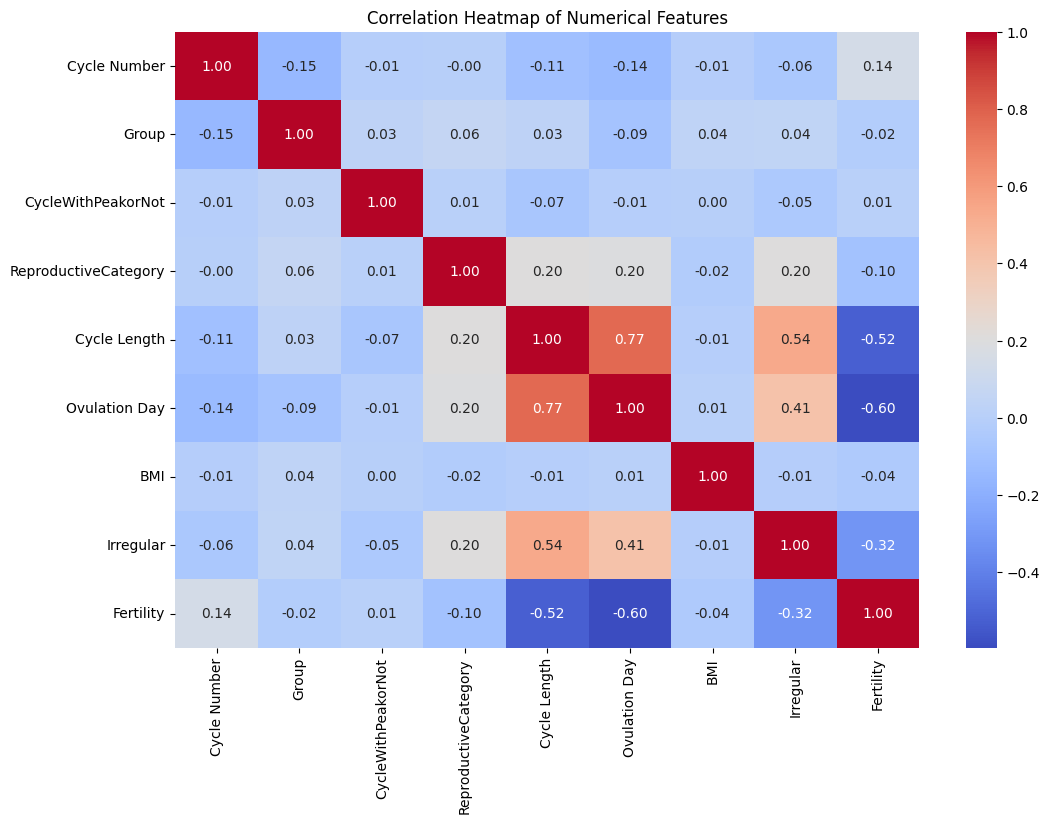

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns from the dataset
numerical_columns = data.select_dtypes(include=["float64", "int64"]).columns

# Compute the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Going to use Random Forest because it helps with multicollinearity. Some things are highly correlated but that makes sense given the topic. 

#Building Blocks

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [19]:
# Define irregular cycles
# Mark as irregular if length is outside 20–40 days or standard deviation is high
mean_length = data["Cycle Length"].mean()
std_dev = data["Cycle Length"].std()

data["Irregular"] = (data["Cycle Length"] < 20) | (data["Cycle Length"] > 40) | (abs(data["Cycle Length"] - mean_length) > 1.5 * std_dev)
data["Irregular"] = data["Irregular"].astype(int)  # Convert to 1 (irregular) or 0 (regular)


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features (X) and target (y)
X = data[["Cycle Number", "BMI", "Ovulation Day"]]
y = data["Irregular"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict irregular cycles
y_pred_irregular = rf_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report for Irregular Cycles:")
print(classification_report(y_test, y_pred_irregular))


Classification Report for Irregular Cycles:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       251
           1       0.77      0.33      0.47        30

    accuracy                           0.92       281
   macro avg       0.85      0.66      0.71       281
weighted avg       0.91      0.92      0.90       281



not very good at recall so we are going to bring outliers back because it is so imbalanced

In [24]:
# Reload the original dataset to reintroduce outliers
data_with_outliers = pd.read_csv("FilteredData.csv")

# Replace blanks with NaN
data_with_outliers = data_with_outliers.replace("", pd.NA)

# Ensure numeric conversion
data_with_outliers["Cycle Length"] = pd.to_numeric(data_with_outliers["LengthofCycle"], errors="coerce")
data_with_outliers["Cycle Number"] = pd.to_numeric(data_with_outliers["CycleNumber"], errors="coerce")
data_with_outliers["Ovulation Day"] = pd.to_numeric(data_with_outliers["EstimatedDayofOvulation"], errors="coerce")

# Remove NaN for critical columns
data_with_outliers = data_with_outliers.dropna(subset=["Cycle Length", "Cycle Number", "Ovulation Day"])


In [25]:
# Define irregular cycles again, including outliers
mean_length = data_with_outliers["Cycle Length"].mean()
std_dev = data_with_outliers["Cycle Length"].std()

data_with_outliers["Irregular"] = (
    (data_with_outliers["Cycle Length"] < 20) |
    (data_with_outliers["Cycle Length"] > 40) |
    (abs(data_with_outliers["Cycle Length"] - mean_length) > 1.5 * std_dev)
).astype(int)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target without BMI
X = data_with_outliers[["Cycle Number", "Ovulation Day"]]  # Exclude BMI
y = data_with_outliers["Irregular"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Train a Random Forest Classifier
rf_clf_no_bmi = RandomForestClassifier(random_state=42)
rf_clf_no_bmi.fit(X_train, y_train)

# Predict on the test set
y_pred_no_bmi = rf_clf_no_bmi.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_no_bmi))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       255
           1       0.64      0.53      0.58        30

    accuracy                           0.92       285
   macro avg       0.79      0.75      0.77       285
weighted avg       0.91      0.92      0.92       285



A little better but still need to fix it more

In [37]:
!pip install imbalanced-learn


  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [38]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
from collections import Counter
print("Balanced Class Distribution:", Counter(y_train_balanced))


Balanced Class Distribution: Counter({1: 670, 0: 670})


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a Random Forest Classifier on the balanced dataset
rf_clf_irregular_balanced = RandomForestClassifier(random_state=42)
rf_clf_irregular_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_balanced = rf_clf_irregular_balanced.predict(X_test)

# Evaluate the model
print("Classification Report for Irregular Cycles (Balanced Data):")
print(classification_report(y_test, y_pred_balanced))


Classification Report for Irregular Cycles (Balanced Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       169

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



In [26]:
# Define fertility again
data_with_outliers["Fertility"] = (
    (data_with_outliers["Ovulation Day"] >= 12) &
    (data_with_outliers["Ovulation Day"] <= 16)
).astype(int)


In [21]:
# Define fertility as higher for ovulation days near the mid-point of the cycle (e.g., day 14)
data["Fertility"] = ((data["Ovulation Day"] >= 12) & (data["Ovulation Day"] <= 16)).astype(int)


In [31]:
# Define features (X) and target (y)
X_fertility = data_with_outliers[["Cycle Number", "Cycle Length", "Ovulation Day"]]
y_fertility = data_with_outliers["Fertility"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_fertility, y_fertility, test_size=0.2, random_state=42)


In [32]:
# Train a Random Forest Classifier for Fertility Prediction
rf_clf_fertility = RandomForestClassifier(random_state=42)
rf_clf_fertility.fit(X_train, y_train)

# Predict on the test set
y_pred_fertility = rf_clf_fertility.predict(X_test)


In [33]:
from sklearn.metrics import classification_report

# Evaluate the Fertility Classifier
print("Classification Report for Fertility Prediction:")
print(classification_report(y_test, y_pred_fertility))


Classification Report for Fertility Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       169

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



Introducing noise to make it better

In [34]:
import numpy as np

# Add noise to the "Ovulation Day" feature
data_with_outliers["Ovulation Day (Noisy)"] = (
    data_with_outliers["Ovulation Day"] + np.random.normal(0, 2, len(data_with_outliers))
)

# Clip negative values
data_with_outliers["Ovulation Day (Noisy)"] = data_with_outliers["Ovulation Day (Noisy)"].clip(lower=0)

# Define features and target
X_fertility_noisy = data_with_outliers[["Cycle Number", "Cycle Length", "Ovulation Day (Noisy)"]]
y_fertility = data_with_outliers["Fertility"]

# Train-test split
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(
    X_fertility_noisy, y_fertility, test_size=0.2, random_state=42
)

# Retrain the Random Forest Classifier
rf_clf_fertility_noisy = RandomForestClassifier(random_state=42)
rf_clf_fertility_noisy.fit(X_train_noisy, y_train_noisy)

# Predict on the test set
y_pred_fertility_noisy = rf_clf_fertility_noisy.predict(X_test_noisy)

# Evaluate
from sklearn.metrics import classification_report

print("Classification Report for Fertility Prediction with Noise:")
print(classification_report(y_test_noisy, y_pred_fertility_noisy))


Classification Report for Fertility Prediction with Noise:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       116
           1       0.84      0.82      0.83       169

    accuracy                           0.80       285
   macro avg       0.79      0.79      0.79       285
weighted avg       0.80      0.80      0.80       285



#Streamlit

In [45]:
from joblib import dump

# Assuming `rf_clf_fertility_noisy` is your fertility prediction model
dump(rf_clf_fertility_noisy, 'rf_model_fertility.joblib')


['rf_model_fertility.joblib']

In [40]:
from joblib import dump

# Save the trained Random Forest model
dump(rf_clf_irregular_balanced, 'rf_model_irregular.joblib')


['rf_model_irregular.joblib']

In [41]:
# Save your data if necessary
data_with_outliers.to_csv("preprocessed_data.csv", index=False)
